# House prices kaggle competition

done by team "А. К., М. М., Д.И."

## Dependencies and imports

In [25]:
!apt-get install graphviz
!pip install graphviz
!pip install fastai==0.7

!mkdir dot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
mkdir: cannot create directory ‘dot’: File exists


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import math
from sklearn import metrics
from sklearn.tree import export_graphviz
import IPython, graphviz, re
from fastai.structured import *

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

## Downloading and assigning our data

In [27]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv

--2018-12-07 11:10:02--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv.1’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.05s   

2018-12-07 11:10:03 (8.64 MB/s) - ‘house_prices_train.csv.1’ saved [460676/460676]

--2018-12-07 11:10:04--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP reques

In [0]:
df_train = pd.read_csv('house_prices_train.csv')
df_test = pd.read_csv('house_prices_test.csv')

## Data exploration

### Analysing our dependent variable

In [29]:
# descibre our dependent variable
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

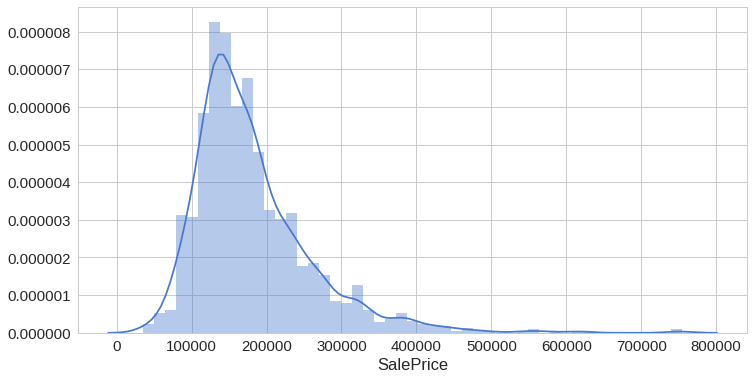

In [30]:
# histogram
sns.distplot(df_train['SalePrice'])

We can see that some of our variables have strong linerar relationship with the dependent variable.

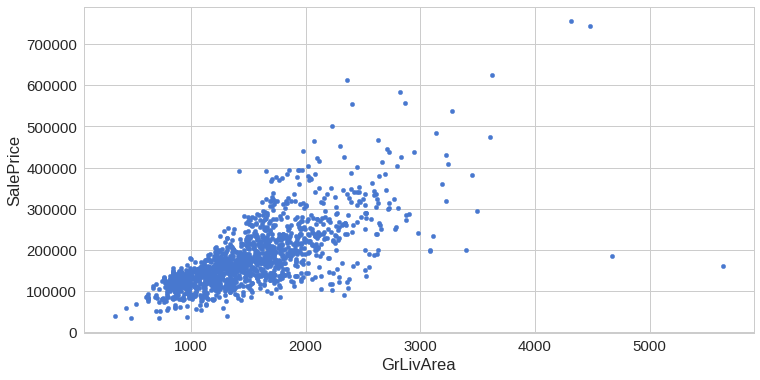

In [31]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

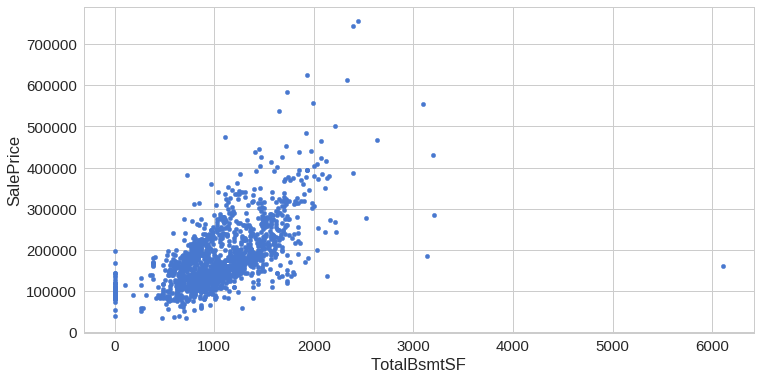

In [32]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

Here we can see that variables like 'OverallQual' and 'TotalBsmtSF' are strongly correlated with the dependent variable.

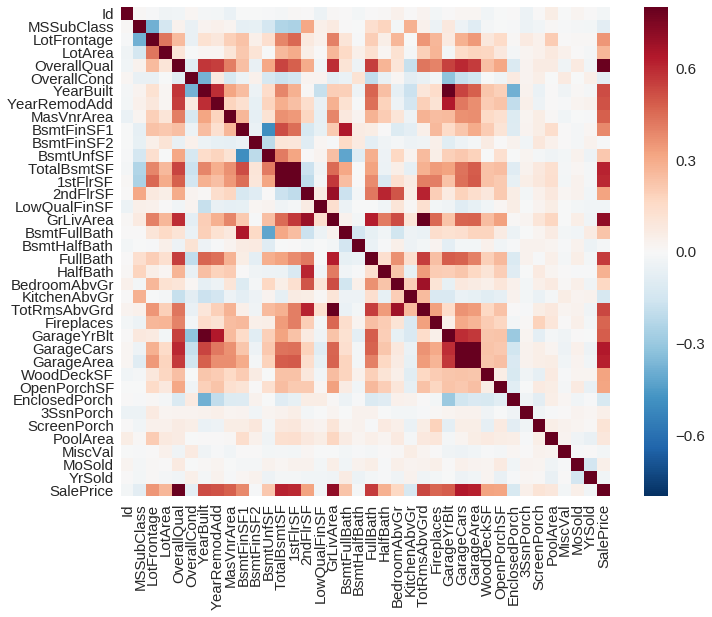

In [33]:
corrmat = df_train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Picking some of the 'strong' variables from above, we make a pairplot finding some really interesting relationships.

<function matplotlib.pyplot.show>

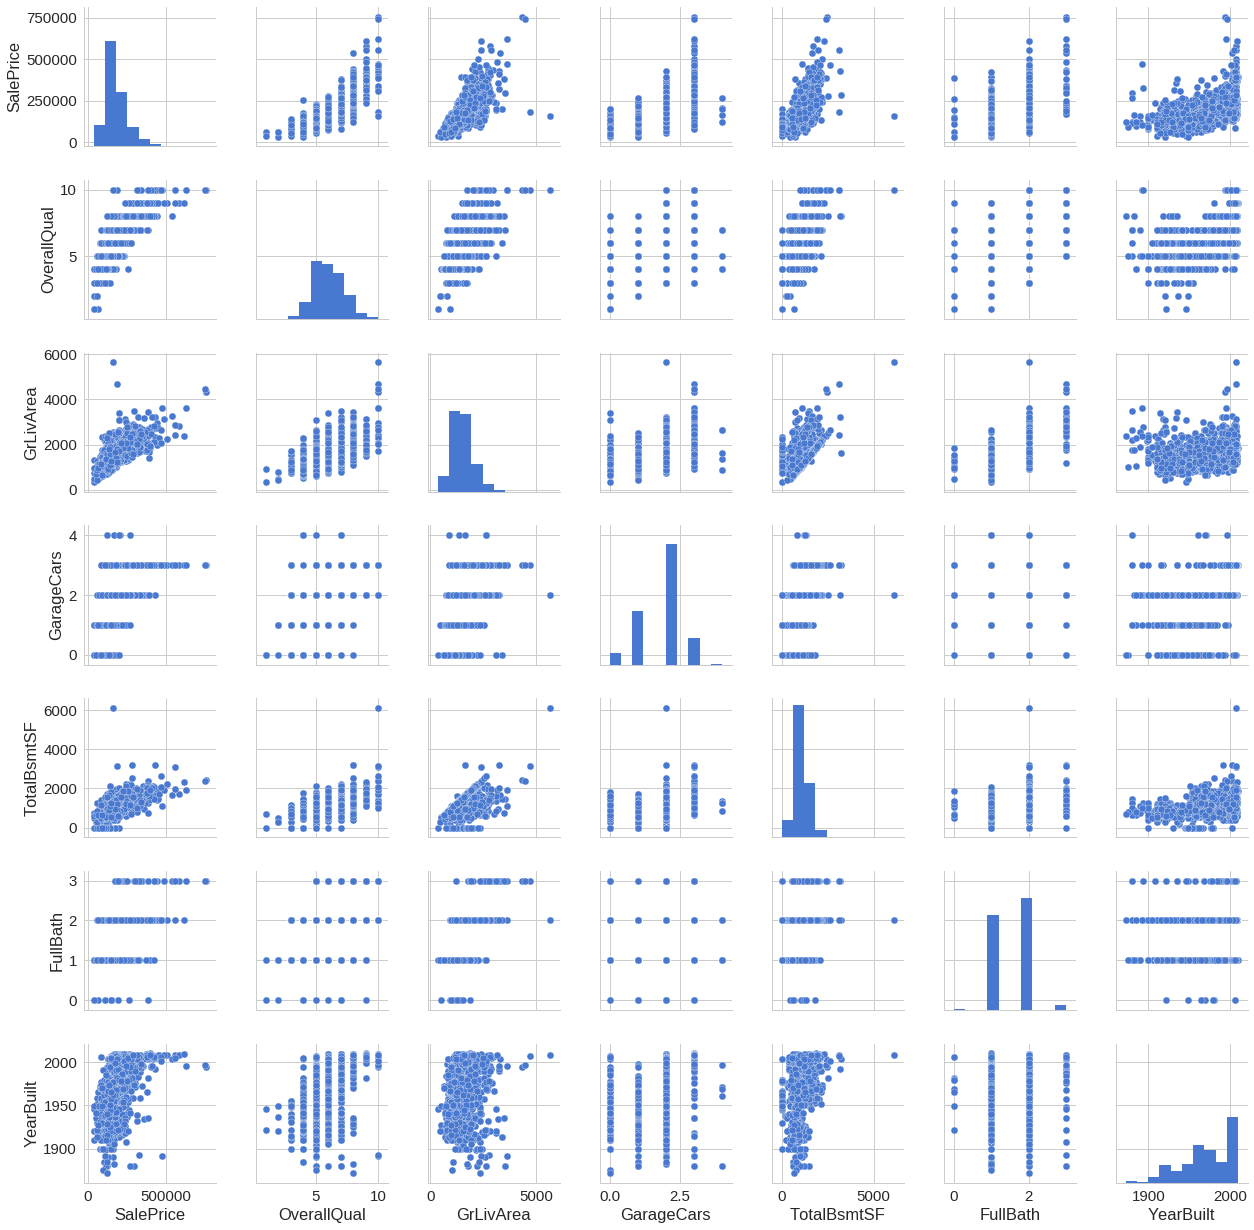

In [34]:
cols=['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size=2.5)
plt.show

## Handling missing values and categorial variables

We see the same tendency in both the train and the test set in terms of missing values. We make the decision that we can get rid of the variables with more than 15% missing values.

In [35]:
print('Missing values in the train set (in percentages):\n')
missing_train = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False) * 100
missing_train.head(20)

Missing values in the train set (in percentages):



PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Utilities        0.000000
dtype: float64

In [36]:
print('Missing values in the test set (in percentages):\n')
missing_test = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False) * 100
missing_test.head(20)

Missing values in the test set (in percentages):



PoolQC          99.794380
MiscFeature     96.504455
Alley           92.666210
Fence           80.123372
FireplaceQu     50.034270
LotFrontage     15.558602
GarageCond       5.346127
GarageQual       5.346127
GarageYrBlt      5.346127
GarageFinish     5.346127
GarageType       5.209047
BsmtCond         3.084304
BsmtQual         3.015764
BsmtExposure     3.015764
BsmtFinType1     2.878684
BsmtFinType2     2.878684
MasVnrType       1.096642
MasVnrArea       1.028101
MSZoning         0.274160
BsmtHalfBath     0.137080
dtype: float64

In [0]:
df_train = df_train.drop((missing_train[missing_train > 15]).index, 1)
df_test = df_test.drop((missing_test[missing_test > 15]).index, 1)

Here we use the `train_cats` method imported from the `fastai` library to turn all object variables into categories.

In [0]:
train_cats(df_train)

`proc_df` assigns all categories their codes and handles all missing values that are left by assigning the mean value of the column.

In [0]:
X, y, nas = proc_df(df_train, 'SalePrice')

## Defining our data structures

We use `rmse` to later see the score of our predictions against the real values.

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(h, y):
  return sqrt(mean_squared_error(h, y))

Here we have the `DecisionTree` we build during our course.

In [0]:
class DecisionTree:

    def __init__(self, x, y, idxs, min_leaf=5):
        self.x = x 
        self.y = y
        self.idxs = idxs 
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for c in range(self.col_count): self.find_better_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0] # lhs indexes
        rhs = np.nonzero(x > self.split)[0] # rhs indexes
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
      
        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]

        for r in range(self.row_count):
            lhs = x <= x[r] # any value in x that is less or equal than this value
            rhs = x > x[r] # any value in x that is greater than this value
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue
            lhs_std = y[lhs].std()
            rhs_std = y[rhs].std()
            curr_score = lhs_std * lhs.sum() + rhs_std * rhs.sum() # weighted average
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'row_count: {self.row_count}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

We use this implementation of a Random Forest to predict the test values.

In [0]:
class RandomForestRegressor():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(RANDOM_SEED)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [0]:
m = RandomForestRegressor(X, y, n_trees=20, sample_sz=200)

We do the same thing to the test set that we did to the train one.

In [0]:
train_cats(df_test)

In [0]:
X_test,_,_ = proc_df(df_test, na_dict=nas)

We test our predictions.

In [0]:
preds_train = m.predict(X.values)

In [47]:
metrics.r2_score(y, preds_train)

0.84312468001887

We then make predictions on the test set and get ready to submit to Kaggle.

In [0]:
preds_test = m.predict(X_test.values)

In [0]:
submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': preds_test})
submission.to_csv('submission.csv', index=False)